In [9]:
from get_archived_data import prepare_gridded_radar_data_from_zip, npy_to_netcdf, get_cpc_quality_code
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# for a single timestep for any product
timestamp = "20210628155500"
product = "HZT" #Freezing level

level_0deg = prepare_gridded_radar_data_from_zip(product=product, timestamp=timestamp)
level_0deg

array([[  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
       [3037.5, 3037.5, 3037.5, ..., 3887.5, 3887.5, 3887.5],
       [3037.5, 3037.5, 3037.5, ..., 3887.5, 3887.5, 3887.5],
       ...,
       [3512.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5],
       [3537.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5],
       [3537.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5]],
      dtype=float32)

In [5]:
20 / 6.5 *1000

3076.923076923077

In [6]:
#get an approximate height of the -20deg line assuming a standard atmosphere (lapse rate of 6.5K/km) https://en.wikipedia.org/wiki/International_Standard_Atmosphere
delta_height = 20 / 6.5 *1000  #20K / (6.5 K/km) *1000 m/km =
approx_m20deg = level_0deg+delta_height

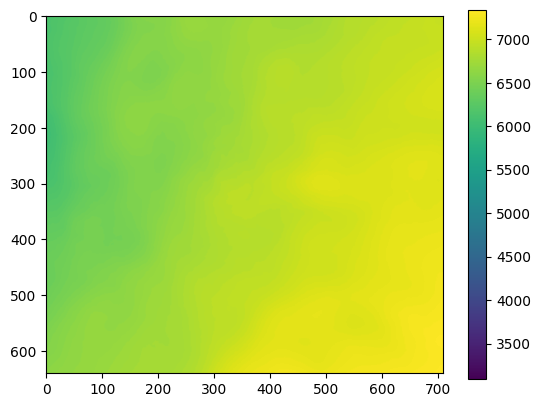

In [7]:
# plt.imshow(level_0deg)
plt.imshow(approx_m20deg)
plt.colorbar()

In [20]:
level_0deg.shape

(640, 710)

In [11]:
# "OZC": ".+.820", #810=1km CAPPI, 820 = 2km CAPPI
{f"OZC_h{km}": f".+.{800+km*10}" for km in np.arange(1,12+1)}

{'OZC_h1': '.+.810',
 'OZC_h2': '.+.820',
 'OZC_h3': '.+.830',
 'OZC_h4': '.+.840',
 'OZC_h5': '.+.850',
 'OZC_h6': '.+.860',
 'OZC_h7': '.+.870',
 'OZC_h8': '.+.880',
 'OZC_h9': '.+.890',
 'OZC_h10': '.+.900',
 'OZC_h11': '.+.910',
 'OZC_h12': '.+.920'}

In [23]:
(height_levels,level_0deg.shape[0],level_0deg.shape[1])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 640, 710)

OZC_h1
OZC_h2
OZC_h3
OZC_h4
OZC_h5
OZC_h6
OZC_h7
OZC_h8
OZC_h9
OZC_h10
OZC_h11
OZC_h12


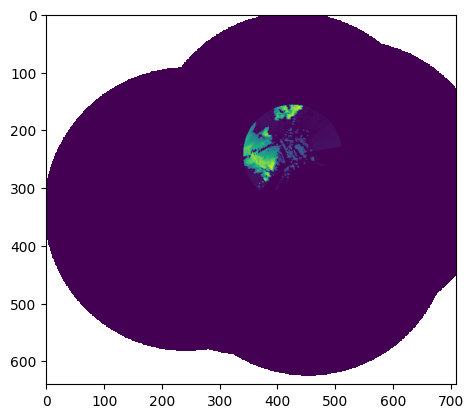

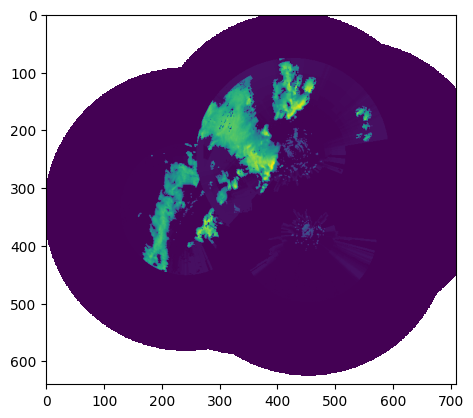

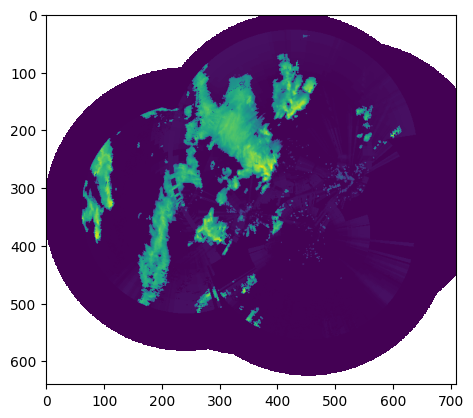

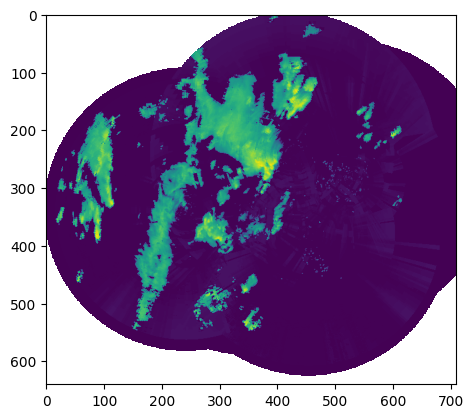

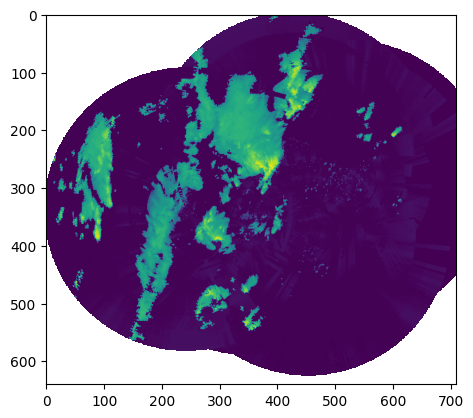

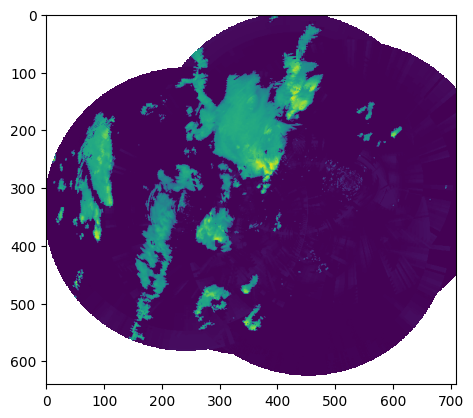

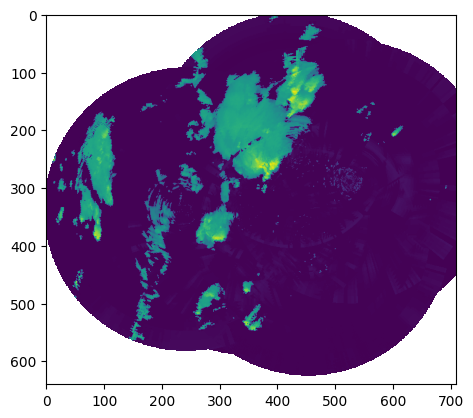

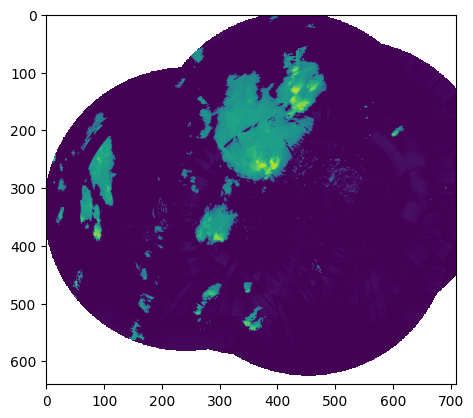

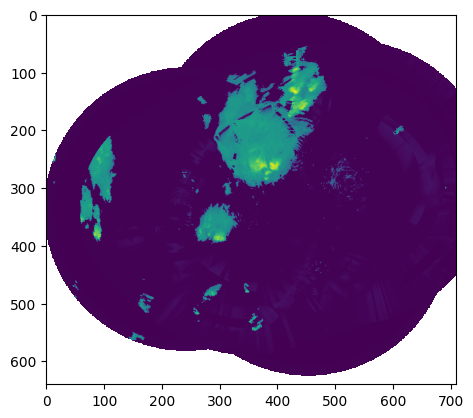

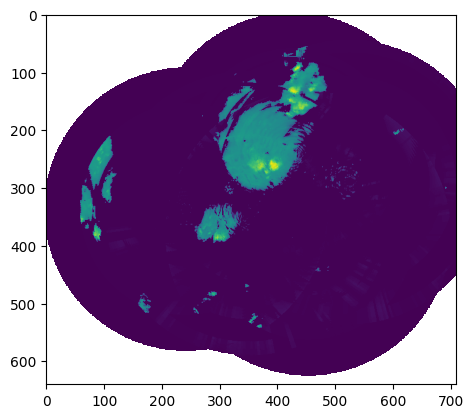

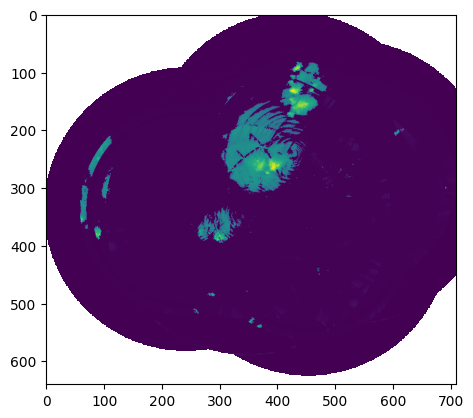

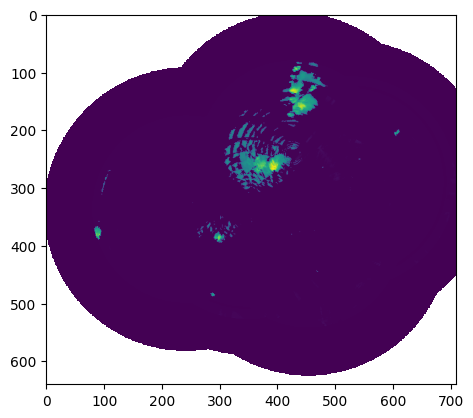

In [25]:
#get Reflectivity CAPPI from heights 1km to 12km (above it get's worse in quality and thunderstorms rarely reach these heights)
height_levels = np.arange(1,12+1)
dBZ_3d = np.empty(shape=(len(height_levels),level_0deg.shape[0],level_0deg.shape[1]))
for i,height in enumerate(height_levels):
    print(f"OZC_h{height}")
    grid = prepare_gridded_radar_data_from_zip(product=f"OZC_h{height}", timestamp=timestamp)
    dBZ_3d[i,:,:] = grid
    plt.figure()
    plt.imshow(grid)

In [27]:
dBZ_3d.shape

(12, 640, 710)

## SHI calculation

In [ ]:
#function definition
def W(Z,Z_L=40,Z_U=50):
    if Z<=Z_L:
        return 0
    elif Z<Z_U:
        return (Z-Z_L)/(Z_U-Z_L)
    else:
        return 1


def Ekin(Z):
    return 5e-6*10**(0.084*Z)*W(Z)

Ekin = np.vectorize(Ekin)

def W_T(h,h0,hm20):
    if h<=h0:
        return 0
    elif h<hm20:
        return (h-h0)/(hm20-h0)
    else:
        return 1



def SHI(h_arr,Z_arr):
    np.testing.assert_array_equal(h_arr,np.sort(h_arr))
    if h_arr[0]>h0:
        raise NotImplementedError('different dH')

    shi=0
    for level in range(len(h_arr)):
        # if h_arr[level]<h0:
        #     continue
        if level==0:
            dH = h_arr[level+1]-h_arr[level]
        elif level == len(h_arr)-1:
            dH = h_arr[level]-h_arr[level-1]
        else:
            dH = (h_arr[level+1]-h_arr[level-1])/2

        shi += W_T(h_arr[level])*Ekin(Z_arr[level])*dH

    shi = 0.1*shi
    return shi

# SHI(heights,dBZ_arr[::-1,4])